In [17]:
from contextlib import contextmanager

FLOPS_ADD = 0
FLOPS_MUL = 0

@contextmanager
def count_flops():
    global FLOPS_ADD, FLOPS_MUL
    FLOPS_ADD = FLOPS_MUL = 0
    yield

def get_flops():
    return FLOPS_ADD + FLOPS_MUL, FLOPS_ADD, FLOPS_MUL

In [18]:
Mat = list[list[float]]

def mat_zeros(n: int, m: int) -> Mat:
    return [[0.0] * m for _ in range(n)]

def mat_rand(n: int, m: int, a: float, b: float) -> Mat:
    from random import uniform
    return [[uniform(a, b) for _ in range(m)] for _ in range(n)]

def mat_slice(a: Mat, i0: int, i1: int, j0: int, j1: int) -> Mat:
    return [row[j0:j1] for row in a[i0:i1]]

def mat_add(a: Mat, b: Mat) -> Mat:
    assert len(a) == len(b)
    assert len(a[0]) == len(b[0])
    n = len(a)
    m = len(a[0])
    global FLOPS_ADD
    FLOPS_ADD += n * m
    return [[a[i][j] + b[i][j] for j in range(m)] for i in range(n)]

In [19]:
def binet_mul(a: Mat, b: Mat) -> Mat:
    assert len(a) == len(a[0]) == len(b) == len(b[0])
    n = len(a)

    if n == 1:
        # base case scalar multiplication
        global FLOPS_MUL
        FLOPS_MUL += 1
        return [[a[0][0] * b[0][0]]]
    else:
        assert n % 2 == 0
        # block size
        m = n // 2
        
        # input blocks
        a11 = mat_slice(a, 0, m, 0, m)
        a12 = mat_slice(a, 0, m, m, n)
        a21 = mat_slice(a, m, n, 0, m)
        a22 = mat_slice(a, m, n, m, n)

        b11 = mat_slice(b, 0, m, 0, m)
        b12 = mat_slice(b, 0, m, m, n)
        b21 = mat_slice(b, m, n, 0, m)
        b22 = mat_slice(b, m, n, m, n)

        # recursive calls
        c11 = mat_add(binet_mul(a11, b11), binet_mul(a12, b21))
        c12 = mat_add(binet_mul(a11, b12), binet_mul(a12, b22))
        c21 = mat_add(binet_mul(a21, b11), binet_mul(a22, b21))
        c22 = mat_add(binet_mul(a21, b12), binet_mul(a22, b22))

        # combine blocks
        c = mat_zeros(n, n)
        for i in range(m):
            for j in range(m):
                c[i][j] = c11[i][j]
                c[i][j + m] = c12[i][j]
                c[i + m][j] = c21[i][j]
                c[i + m][j + m] = c22[i][j]

        return c

In [20]:
def test_mat_mul(ns):
    import numpy as np

    for n in ns:
        a = mat_rand(n, n, -1, 1)
        b = mat_rand(n, n, -1, 1)
        c = binet_mul(a, b)
        d = np.matmul(a, b)
        assert np.allclose(c, d)

test_mat_mul([1, 2, 4, 8, 16, 32, 64])
print('OK')

OK


In [21]:
with count_flops():
    a = mat_rand(32, 32, -1, 1)
    b = mat_rand(32, 32, -1, 1)
    c = binet_mul(a, b)
    flops, add, mul = get_flops()
    print('FLOPS', 'ADD', 'MUL', sep='\t')
    print(flops, add, mul, sep='\t')

FLOPS	ADD	MUL
64512	31744	32768


In [22]:
from tqdm import tqdm
from timeit import timeit
import numpy as np

ns = [2**i for i in range(2, 9)]
times1 = []
times2 = []
flops1 = []

for n in tqdm(ns):
    a = mat_rand(n, n, -1, 1)
    b = mat_rand(n, n, -1, 1)
    
    with count_flops():
        t1 = timeit(lambda: binet_mul(a, b), number=1)
    f1, _, _ = get_flops()
    
    t2 = timeit(lambda: np.matmul(a, b), number=100) / 100

    times1.append(t1)
    times2.append(t2)
    flops1.append(f1)

100%|██████████| 7/7 [00:19<00:00,  2.79s/it]


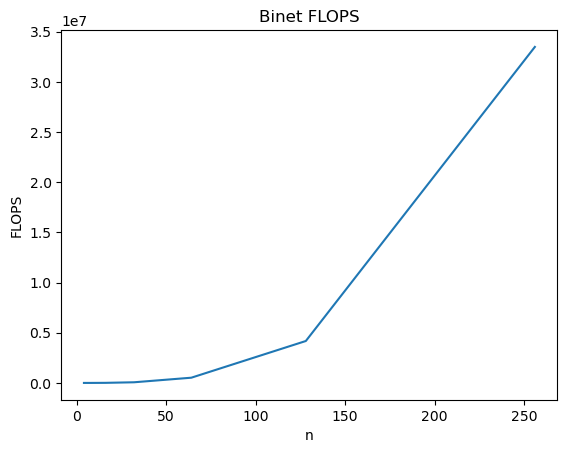

In [23]:
import matplotlib.pyplot as plt

plt.plot(ns, flops1)
plt.title('Binet FLOPS')
plt.xlabel('n')
plt.ylabel('FLOPS')
plt.show()

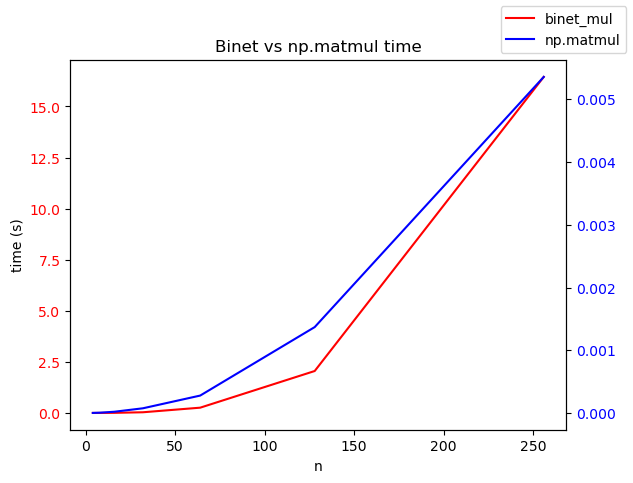

In [24]:
fig, ax1 = plt.subplots()
ax1.set_xlabel('n')
ax1.set_ylabel('time (s)')
ax1.tick_params(axis='y', labelcolor='red')
ax1.plot(ns, times1, label='binet_mul', color='red')

ax2 = ax1.twinx()
ax2.tick_params(axis='y', labelcolor='blue')
ax2.plot(ns, times2, label='np.matmul', color='blue')

fig.legend()
plt.title('Binet vs np.matmul time')
plt.show()